# Framework ACO genérico (Ant Colony Optimization)

Este notebook contiene un framework genérico para ACO.
El diseño está pensado para máxima flexibilidad: separa **Problema**, **Hormiga**, **Regla de transición**, **Actualización de feromonas** y **Estrategias de búsqueda local** mediante el patrón *Strategy*.

## Conceptos claves (fórmulas)

Sea $\tau_{ij}$ la feromona en el arco $i \to j$, y $\eta_{ij}$ la heurística (por ejemplo $1/d_{ij}$ si hay distancias). La probabilidad de seleccionar $j$ desde $i$ es:

$$
P_{ij} = \frac{(\tau_{ij})^\alpha \cdot (\eta_{ij})^\beta}{\sum_{k \in \mathcal{N}(i)} (\tau_{ik})^\alpha \cdot (\eta_{ik})^\beta}
$$

Actualización típica (evaporación + depósito):

$$
\tau_{ij} \leftarrow (1 - \rho)\tau_{ij} + \sum_{a \in \text{ants}} \Delta\tau_{ij}^a
$$

donde $\rho$ es la tasa de evaporación y $\Delta\tau_{ij}^a$ es el depósito por la hormiga $a$ (por ejemplo inverso del coste).

## Diseño del framework

- **ProblemProtocol**: interfaz que tu problema debe implementar (espacio de búsqueda, coste, factibilidad).
- **TransitionRuleStrategy**: define cómo escoger el siguiente movimiento (ruleta, argmax con exploración, etc.).
- **PheromoneUpdateStrategy**: múltiples implementaciones (estándar, elitista, max-min, best-worst).
- **LocalSearchStrategy**: opcional, aplica optimizaciones locales sobre soluciones.
- **Colony**: orquesta la construcción de soluciones, aplicación de búsqueda local y actualización de feromonas.

## Uso (esquema)
1. Implementa `ProblemProtocol` para tu problema concreto.
2. Crea instancias de `TransitionRuleStrategy`, `PheromoneUpdateStrategy` y (opcional) `LocalSearchStrategy`.
3. Crea la `Colony` con parámetros (n_ants, generaciones, alpha, beta, etc.).
4. Ejecuta `colony.run()` y consulta `colony.best_solution` y `colony.best_cost`.



In [32]:
import math
from collections.abc import Sequence, Iterable, Callable
from dataclasses import dataclass, field
from itertools import chain
from time import time
from typing import runtime_checkable, Protocol, Any
from random import Random

from matplotlib import pyplot as plt

In [12]:
@runtime_checkable
class ProblemProtocol(Protocol):
    """Interfaz que debe implementar el problema concreto.

    Notas:
        - Un "estado" puede representarse como una secuencia de nodos/decisiones.
        - El framework asume que el problema provee un conjunto de nodos/posiciones
          y métodos para obtener movimientos razonables y coste de una solución.

    Métodos obligatorios:
        - num_elements(): número de elementos (nodos).
        - start_element(): elemento inicial (si aplica) o None.
        - feasible_neighbors(current, visited) -> Iterable[next_element]
        - is_solution_complete(solution) -> bool
        - evaluate(solution) -> float: coste objetivo (a minimizar).
        - heuristic(i, j) -> float: heurística entre i y j (si aplica). Debe ser > 0.
    """

    def num_elements(self) -> int: ...

    def start_element(self) -> Any | None: ...

    def feasible_neighbors(
        self, current: Any, visited: Sequence[Any]
    ) -> Iterable[Any]: ...

    def is_solution_complete(self, solution: Sequence[Any]) -> bool: ...

    def evaluate(self, solution: Sequence[Any]) -> float: ...

    def heuristic(self, i: Any, j: Any) -> float: ...

In [13]:
@dataclass
class PheromoneMatrix:
    """Matriz genérica de feromonas indexada por pares (i, j).

    Puede almacenar feromonas en una matriz (si elementos indexables por entero) o en dict.
    """

    elements: Sequence[Any]
    initial_pheromone: float = 1.0
    symmetric: bool = False
    _data: dict[tuple[int, int], float] = field(
        default_factory=dict[tuple[int, int], float], init=False
    )

    def __post_init__(self) -> None:
        n = len(self.elements)
        for i in range(n):
            for j in range(n):
                self._data[(i, j)] = self.initial_pheromone

    def index_of(self, element: Any) -> int:
        try:
            return self.elements.index(element)
        except ValueError as e:
            raise KeyError(
                f"Elemento {element} no encontrado en PheromoneMatrix"
            ) from e

    def get(self, i: Any, j: Any) -> float:
        ii = self.index_of(i) if not isinstance(i, int) else i
        jj = self.index_of(j) if not isinstance(j, int) else j
        return self._data[(ii, jj)]

    def set(self, i: Any, j: Any, value: float) -> None:
        ii = self.index_of(i) if not isinstance(i, int) else i
        jj = self.index_of(j) if not isinstance(j, int) else j
        self._data[(ii, jj)] = value
        if self.symmetric:
            self._data[(jj, ii)] = value

    def items(self) -> Iterable[tuple[tuple[int, int], float]]:
        return self._data.items()

    def decay_all(self, rho: float) -> None:
        """Evaporación multiplicativa: tau <- (1 - rho) * tau."""
        for k in self._data.keys():
            self._data[k] *= 1.0 - rho

    def clamp(self, min_val: float, max_val: float) -> None:
        """Limita los valores de feromona al rango [min_val, max_val]."""
        for k, v in self._data.items():
            if v < min_val:
                self._data[k] = min_val
            elif v > max_val:
                self._data[k] = max_val


In [28]:
@runtime_checkable
class TransitionRuleStrategy(Protocol):
    """Estrategia para elegir el siguiente elemento durante la construcción de la solución."""

    def select_next(
        self,
        current: Any,
        visited: Sequence[Any],
        candidate_neighbors: Sequence[Any],
        pheromone: PheromoneMatrix,
        problem: ProblemProtocol,
        alpha: float,
        beta: float,
        rng: Random,
    ) -> Any:
        """Selecciona el siguiente elemento a visitar."""


@runtime_checkable
class PheromoneUpdateStrategy(Protocol):
    """Estrategia para actualizar la matriz de feromonas después de una iteración."""

    def update(
        self,
        pheromone: PheromoneMatrix,
        ants: Sequence["Ant"],
        colony: "Colony",
        rng: Random,
    ) -> None:
        """Actualiza la matriz de feromonas."""


@runtime_checkable
class LocalSearchStrategy(Protocol):
    """Estrategia opcional para mejorar soluciones individuales."""

    def improve(
        self, solution: Sequence[Any], problem: ProblemProtocol, rng: Random
    ) -> Sequence[Any]:
        """Mejora una solución dada y devuelve la solución mejorada."""
        ...


In [15]:
@dataclass
class Ant:
    """Representación de una hormiga constructora de soluciones."""

    problem: ProblemProtocol
    pheromone: PheromoneMatrix
    transition_rule: TransitionRuleStrategy
    alpha: float = 1.0
    beta: float = 2.0
    rng: Random | None = None
    solution: list[Any] = field(default_factory=list[Any], init=False)
    cost: float | None = field(default=None, init=False)

    def __post_init__(self) -> None:
        if self.rng is None:
            self.rng = Random()

    def reset(self) -> None:
        self.solution = []
        self.cost = None

    def construct_solution(self) -> None:
        """Construye una solución paso a paso usando la estrategia de transición."""
        self.reset()
        start = self.problem.start_element()
        if start is not None:
            current = start
            self.solution.append(current)
        else:
            # Si no hay elemento de inicio, el primer elemento será seleccionado entre todos
            elements = list(self.pheromone.elements)
            current = self.rng.choice(elements) if self.rng else Random().choice(elements)
            self.solution.append(current)

        while not self.problem.is_solution_complete(self.solution):
            neighbors = list(self.problem.feasible_neighbors(current, self.solution))
            if not neighbors:
                # No hay movimientos factibles -> terminamos (problema mal planteado o solución incompleta)
                break
            next_node = self.transition_rule.select_next(
                current=current,
                visited=self.solution,
                candidate_neighbors=neighbors,
                pheromone=self.pheromone,
                problem=self.problem,
                alpha=self.alpha,
                beta=self.beta,
                rng=self.rng or Random(),
            )
            self.solution.append(next_node)
            current = next_node

        self.cost = self.problem.evaluate(self.solution)

    def get_solution(self) -> tuple[list[Any], float]:
        if self.cost is None:
            self.cost = self.problem.evaluate(self.solution)
        return self.solution, self.cost


In [16]:
class RouletteWheelTransition:
    """Selección probabilística (ruleta) basada en feromona^alpha * heurística^beta."""

    def select_next(
        self,
        current: Any,
        visited: Sequence[Any],
        candidate_neighbors: Sequence[Any],
        pheromone: PheromoneMatrix,
        problem: ProblemProtocol,
        alpha: float,
        beta: float,
        rng: Random,
    ) -> Any:
        weights: list[float] = []
        for nb in candidate_neighbors:
            tau = pheromone.get(current, nb)
            eta = problem.heuristic(current, nb)
            weight = (tau**alpha) * (eta**beta)
            weights.append(max(weight, 1e-12))  # evitar 0

        total = sum(weights)
        if total == 0:
            # fallback a elección uniforme
            return rng.choice(candidate_neighbors)

        # ruleta
        pick = rng.random() * total
        acc = 0.0
        for nb, w in zip(candidate_neighbors, weights):
            acc += w
            if pick <= acc:
                return nb
        return candidate_neighbors[-1]  # fallback


class GreedyWithProbabilisticExploration:
    """Selecciona argmax con probabilidad (1 - q0) usa ruleta, con prob q0 elige mejor (Ant System / ACS style)."""

    def __init__(self, q0: float = 0.9):
        self.q0 = q0

    def select_next(
        self,
        current: Any,
        visited: Sequence[Any],
        candidate_neighbors: Sequence[Any],
        pheromone: PheromoneMatrix,
        problem: ProblemProtocol,
        alpha: float,
        beta: float,
        rng: Random,
    ) -> Any:
        scored: list[tuple[float, Any]] = []
        for nb in candidate_neighbors:
            tau = pheromone.get(current, nb)
            eta = problem.heuristic(current, nb)
            scored.append(((tau**alpha) * (eta**beta), nb))
        scored.sort(reverse=True, key=lambda x: x[0])
        if rng.random() < self.q0:
            return scored[0][1]
        # otherwise ruleta entre todos (basada en puntuaciones)
        weights = [s for s, _ in scored]
        total = sum(weights)
        if total == 0:
            return rng.choice(candidate_neighbors)
        pick = rng.random() * total
        acc = 0.0
        for w, nb in scored:
            acc += w
            if pick <= acc:
                return nb
        return scored[-1][1]


In [17]:
@dataclass
class StandardPheromoneUpdate:
    """Actualización básica de feromonas tipo Ant System.

    Depósito por hormiga: deposit = Q / cost
    """

    rho: float = 0.1
    Q: float = 1.0

    def update(
        self,
        pheromone: PheromoneMatrix,
        ants: Sequence[Ant],
        colony: "Colony",
        rng: Random,
    ) -> None:
        pheromone.decay_all(self.rho)
        for ant in ants:
            solution, cost = ant.get_solution()
            if cost <= 0:
                continue
            deposit = self.Q / cost
            # depositar feromona en cada par consecutivo de la solución
            for a, b in zip(solution[:-1], solution[1:]):
                prev = pheromone.get(a, b)
                pheromone.set(a, b, prev + deposit)


@dataclass
class ElitistPheromoneUpdate:
    """Actualización elitista: además de depósitos individuales, se añade extra del mejor global."""

    base_update: StandardPheromoneUpdate
    elitist_weight: float = 5.0

    def update(
        self,
        pheromone: PheromoneMatrix,
        ants: Sequence[Ant],
        colony: "Colony",
        rng: Random,
    ) -> None:
        # aplicar evaporación y depósitos básicos
        self.base_update.update(pheromone, ants, colony, rng)
        # añadir depósito elitista por best global
        if colony.best_solution is None:
            return
        solution, cost = colony.best_solution
        if cost <= 0:
            return
        deposit = (self.base_update.Q / cost) * self.elitist_weight
        for a, b in zip(solution[:-1], solution[1:]):
            prev = pheromone.get(a, b)
            pheromone.set(a, b, prev + deposit)


@dataclass
class MaxMinPheromoneUpdate:
    """Max-Min Ant System (MMAS) style: fija min/max y deposita solo por las mejores."""

    rho: float = 0.1
    Q: float = 1.0
    min_tau: float = 0.1
    max_tau: float = 5.0
    use_global_best: bool = True

    def update(
        self,
        pheromone: PheromoneMatrix,
        ants: Sequence[Ant],
        colony: "Colony",
        rng: Random,
    ) -> None:
        pheromone.decay_all(self.rho)
        # escoger la solución que va a depositar: global best o mejor de ésta iteración
        chosen = None
        if self.use_global_best and colony.best_solution is not None:
            chosen = colony.best_solution
        else:
            # mejor de la iteración
            iter_best = min(
                (ant.get_solution() for ant in ants), key=lambda sc: sc[1], default=None
            )
            chosen = iter_best
        if not chosen:
            return
        solution, cost = chosen
        if cost <= 0:
            return
        deposit = self.Q / cost
        for a, b in zip(solution[:-1], solution[1:]):
            prev = pheromone.get(a, b)
            pheromone.set(a, b, prev + deposit)
        # aplicar límites
        pheromone.clamp(self.min_tau, self.max_tau)


@dataclass
class BestWorstPheromoneUpdate:
    """Depósito por el mejor, y penalización por el peor (best-worst)."""

    rho: float = 0.1
    Q: float = 1.0
    worst_penalty: float = 0.5

    def update(
        self,
        pheromone: PheromoneMatrix,
        ants: Sequence[Ant],
        colony: "Colony",
        rng: Random,
    ) -> None:
        pheromone.decay_all(self.rho)
        ants_solutions = [
            ant.get_solution() for ant in ants if ant.get_solution()[1] is not None
        ]
        if not ants_solutions:
            return
        best = min(ants_solutions, key=lambda sc: sc[1])
        worst = max(ants_solutions, key=lambda sc: sc[1])

        # depositar por el mejor
        solution, cost = best
        if cost > 0:
            deposit = self.Q / cost
            for a, b in zip(solution[:-1], solution[1:]):
                prev = pheromone.get(a, b)
                pheromone.set(a, b, prev + deposit)

        # penalizar por el peor (reducir feromona)
        w_solution, w_cost = worst
        if w_cost > 0:
            penalty = self.worst_penalty * (self.Q / w_cost)
            for a, b in zip(w_solution[:-1], w_solution[1:]):
                prev = pheromone.get(a, b)
                pheromone.set(a, b, max(0.0, prev - penalty))


In [18]:
@dataclass
class Colony:
    """Clase que orquesta la ejecución del algoritmo ACO.

    Attributes:
        problem: ProblemProtocol implementado por el usuario.
        num_ants: número de hormigas por iteración.
        generations: número de iteraciones.
        pheromone_matrix: PheromoneMatrix
        transition_rule: TransitionRuleStrategy
        pheromone_update: PheromoneUpdateStrategy
        local_search: LocalSearchStrategy|None (opcional)
        alpha, beta: parámetros de influencia de feromona y heurística.
        rng_seed: semilla para reproducibilidad.
    """

    problem: ProblemProtocol
    num_ants: int = 10
    generations: int = 100
    pheromone_matrix: PheromoneMatrix | None = None
    transition_rule: TransitionRuleStrategy | None = None
    pheromone_update: PheromoneUpdateStrategy | None = None
    local_search: LocalSearchStrategy | None = None
    alpha: float = 1.0
    beta: float = 2.0
    rng_seed: int | None = None
    verbose: bool = False
    # resultados
    best_solution: tuple[list[Any], float] | None = field(default=None, init=False)

    def __post_init__(self) -> None:
        self.rng = Random(self.rng_seed)
        if self.pheromone_matrix is None:
            # por defecto: elementos = range(num_elements)
            elements = [i for i in range(self.problem.num_elements())]
            self.pheromone_matrix = PheromoneMatrix(
                elements=elements, initial_pheromone=1.0, symmetric=False
            )

        if self.transition_rule is None:
            self.transition_rule = RouletteWheelTransition()

        if self.pheromone_update is None:
            self.pheromone_update = StandardPheromoneUpdate()

        # validaciones ligeras
        assert isinstance(self.pheromone_matrix, PheromoneMatrix)
        assert isinstance(self.transition_rule, TransitionRuleStrategy) or hasattr( # type: ignore
            self.transition_rule, "select_next"
        )
        assert hasattr(self.pheromone_update, "update")

    def _create_ant(self) -> Ant:
        return Ant(
            problem=self.problem,
            pheromone=self.pheromone_matrix, # type: ignore
            transition_rule=self.transition_rule, # type: ignore
            alpha=self.alpha,
            beta=self.beta,
            rng=Random(self.rng.random()),
        )

    def run(self) -> None:
        """Ejecuta el algoritmo ACO durante `generations` iteraciones."""
        for gen in range(1, self.generations + 1):
            ants = [self._create_ant() for _ in range(self.num_ants)]
            # construcción de soluciones
            for ant in ants:
                ant.construct_solution()
                # aplicar búsqueda local si existe
                if self.local_search is not None and ant.solution:
                    improved = self.local_search.improve(
                        ant.solution, self.problem, ant.rng # type: ignore
                    )
                    if improved is not None: # type: ignore
                        ant.solution = list(improved)
                        ant.cost = self.problem.evaluate(ant.solution)

            # actualizar mejor global
            for ant in ants:
                if ant.cost is None:
                    continue
                if self.best_solution is None or ant.cost < self.best_solution[1]:
                    self.best_solution = (list(ant.solution), ant.cost)

            # actualizar feromonas
            if self.pheromone_update is not None:
                self.pheromone_update.update( # type: ignore
                    self.pheromone_matrix, ants, self, self.rng # type: ignore
                )

            if self.verbose and gen % max(1, self.generations // 10) == 0:
                print(
                    f"[Gen {gen}/{self.generations}] best_cost = {self.best_solution[1] if self.best_solution else None}"
                )

    def get_best(self) -> tuple[list[Any], float] | None:
        """Devuelve la mejor solución registrada (solution, cost)."""
        return self.best_solution


In [19]:
class TemplateProblem(ProblemProtocol):
    """Plantilla / ejemplo de cómo implementar `ProblemProtocol`.

    RECUERDA: No es una implementación concreta de un problema: debes sustituir
    los métodos por la lógica de tu propio problema (TSP, VRP, scheduling, etc).
    """

    def __init__(
        self,
        elements: Sequence[Any],
        heuristic_fn: Callable[[Any, Any], float] | None = None,
    ):
        self._elements = list(elements)
        self._heuristic_fn = heuristic_fn or (lambda i, j: 1.0) # type: ignore

    def num_elements(self) -> int:
        return len(self._elements)

    def start_element(self) -> Any | None:
        # por defecto no hay elemento inicial fijo
        return None

    def feasible_neighbors(self, current: Any, visited: Sequence[Any]) -> Iterable[Any]:
        # por defecto permite visitar cualquier elemento no visitado
        for e in self._elements:
            if e not in visited:
                yield e

    def is_solution_complete(self, solution: Sequence[Any]) -> bool:
        # por defecto: solución completa si visitó todos los elementos
        return len(solution) >= len(self._elements)

    def evaluate(self, solution: Sequence[Any]) -> float:
        # Debes implementar la función que calcule el coste de `solution`.
        # Aquí solo un placeholder que falla si no se sobrescribe:
        raise NotImplementedError(
            "Implementa `evaluate(solution)` en tu problema concreto."
        )

    def heuristic(self, i: Any, j: Any) -> float:
        return float(self._heuristic_fn(i, j)) # type: ignore


In [20]:
def seed_random(seed: int | None = None) -> Random:
    return Random(seed)


## Estrategias locales: 2-opt y 3-opt

Estas estrategias son *local search* para mejorar soluciones construidas por ACO.

### 2-opt

2-opt elimina dos aristas $(i,i+1)$ y $(k,k+1)$ y las reconecta como $(i,k)$ y $(i+1,k+1)$, lo que equivale a invertir un tramo de la ruta.
La variación de coste idealizada (si se conoce la métrica $d$) es:

$$
\Delta = \big(d(i,k) + d(i+1, k+1)\big) - \big(d(i,i+1) + d(k,k+1)\big).
$$

En esta implementación no se asume una función `d(i,j)` disponible: cada vecino se evalúa con `problem.evaluate(solution_candidate)`. Se aplica iterativamente hasta convergencia o hasta un número máximo de iteraciones.

### 3-opt

3-opt elimina tres aristas y prueba las reconexiones válidas de los tres segmentos resultantes. Hay varias configuraciones posibles (incluyendo algunas que son equivalentes a combinaciones de 2-opt). El método aquí genera las reconexiones posibles (evitando duplicados) y selecciona la mejor.

### Parámetros importantes

- `max_iterations`: número máximo de iteraciones de la mejora (por defecto 100).
- `improvement`: `"best"` (busca mejora global y la aplica) o `"first"` (aplica la primera mejora encontrada).
- `verbose`: imprime progreso si es `True`.

### Uso

Pasa una instancia a `Colony(local_search=TwoOptLocalSearch(...))` o `ThreeOptLocalSearch(...)`.
La estrategia recibe y devuelve una `Sequence[Any]` que representa la solución (mantiene el cierre si la solución original estaba cerrada).


In [22]:
@dataclass
class TwoOptLocalSearch(LocalSearchStrategy):
    """Implementación de 2-opt como LocalSearchStrategy.

    Args:
        max_iterations: máximo de iteraciones de mejora (por defecto 100).
        improvement: "best" (mejor mejora) o "first" (primera mejora encontrada).
        verbose: imprime información si es True.
    """

    max_iterations: int = 100
    improvement: str = "best"  # "best" o "first"
    verbose: bool = False

    def improve(
        self, solution: Sequence[Any], problem: ProblemProtocol, rng: Random
    ) -> Sequence[Any]:
        # Convertir a lista para manipular
        sol = list(solution)
        closed = len(sol) > 1 and sol[0] == sol[-1]
        if closed:
            tour = sol[:-1]  # trabajar sobre n nodos sin duplicar el primero al final
        else:
            tour = sol

        n = len(tour)
        if n < 4:  # nada que optimizar con 2-opt si n < 4 (o n < 3 para tours)
            return solution

        best_tour = tour
        best_cost = problem.evaluate(self._close_if_needed(best_tour, closed))
        it = 0
        improved = True

        while improved and it < self.max_iterations:
            it += 1
            improved = False
            if self.improvement == "best":
                candidate_best_cost = best_cost
                candidate_best_tour = best_tour
                # explorar todo el vecindario
                for i in range(0, n - 1):
                    for k in range(i + 1, n):
                        new_tour = self._two_opt_swap(best_tour, i, k)
                        new_cost = problem.evaluate(
                            self._close_if_needed(new_tour, closed)
                        )
                        if new_cost < candidate_best_cost - 1e-12:
                            candidate_best_cost = new_cost
                            candidate_best_tour = new_tour
                if candidate_best_cost < best_cost - 1e-12:
                    best_tour = candidate_best_tour
                    best_cost = candidate_best_cost
                    improved = True
            else:  # first improvement
                for i in range(0, n - 1):
                    found = False
                    for k in range(i + 1, n):
                        new_tour = self._two_opt_swap(best_tour, i, k)
                        new_cost = problem.evaluate(
                            self._close_if_needed(new_tour, closed)
                        )
                        if new_cost < best_cost - 1e-12:
                            best_tour = new_tour
                            best_cost = new_cost
                            improved = True
                            found = True
                            break
                    if found:
                        break

            if self.verbose:
                print(f"[2-opt] iter {it} -> best_cost {best_cost}")

        final_solution = self._close_if_needed(best_tour, closed)
        return final_solution

    @staticmethod
    def _two_opt_swap(tour: list[Any], i: int, k: int) -> list[Any]:
        """Realiza la operación 2-opt: invierte el segmento (i+1..k) inclusive en la definición clásica."""
        # Tour assumed list of nodes
        if i >= k:
            return tour[:]
        new_tour = tour[: i + 1] + list(reversed(tour[i + 1 : k + 1])) + tour[k + 1 :]
        return new_tour

    @staticmethod
    def _close_if_needed(tour: list[Any], closed: bool) -> list[Any]:
        if closed:
            return tour + [tour[0]]
        return tour


@dataclass
class ThreeOptLocalSearch(LocalSearchStrategy):
    """Implementación simple de 3-opt.

    Genera reconexiones basadas en particionar el tour en tres segmentos y probar
    las combinaciones de orden/reverso de los segmentos. Es costosa (O(n^3) vecindario),
    por eso tiene `max_iterations` y opción "first" o "best".
    """

    max_iterations: int = 50
    improvement: str = "best"  # "best" o "first"
    verbose: bool = False

    def improve(
        self, solution: Sequence[Any], problem: ProblemProtocol, rng: Random
    ) -> Sequence[Any]:
        sol = list(solution)
        closed = len(sol) > 1 and sol[0] == sol[-1]
        if closed:
            tour = sol[:-1]
        else:
            tour = sol

        n = len(tour)
        if n < 5:  # 3-opt requiere al menos 5 nodos para movimientos significativos
            return solution

        best_tour = tour
        best_cost = problem.evaluate(self._close_if_needed(best_tour, closed))
        it = 0
        improved = True

        while improved and it < self.max_iterations:
            it += 1
            improved = False
            if self.improvement == "best":
                candidate_best_cost = best_cost
                candidate_best_tour = best_tour
                # iterar i < j < k
                for i in range(0, n - 2):
                    for j in range(i + 1, n - 1):
                        for k in range(j + 1, n):
                            candidate_tours = self._generate_3opt_candidates(
                                best_tour, i, j, k
                            )
                            for new_tour in candidate_tours:
                                new_cost = problem.evaluate(
                                    self._close_if_needed(new_tour, closed)
                                )
                                if new_cost < candidate_best_cost - 1e-12:
                                    candidate_best_cost = new_cost
                                    candidate_best_tour = new_tour
                if candidate_best_cost < best_cost - 1e-12:
                    best_tour = candidate_best_tour
                    best_cost = candidate_best_cost
                    improved = True
            else:  # first improvement
                found_any = False
                for i in range(0, n - 2):
                    if found_any:
                        break
                    for j in range(i + 1, n - 1):
                        if found_any:
                            break
                        for k in range(j + 1, n):
                            candidate_tours = self._generate_3opt_candidates(
                                best_tour, i, j, k
                            )
                            for new_tour in candidate_tours:
                                new_cost = problem.evaluate(
                                    self._close_if_needed(new_tour, closed)
                                )
                                if new_cost < best_cost - 1e-12:
                                    best_tour = new_tour
                                    best_cost = new_cost
                                    improved = True
                                    found_any = True
                                    break
                            if found_any:
                                break
                        if found_any:
                            break
                    if found_any:
                        break

            if self.verbose:
                print(f"[3-opt] iter {it} -> best_cost {best_cost}")

        return self._close_if_needed(best_tour, closed)

    @staticmethod
    def _generate_3opt_candidates(
        tour: list[Any], i: int, j: int, k: int
    ) -> list[list[Any]]:
        """Genera reconexiones 3-opt a partir de índices i<j<k.

        Particiona el tour en: A = tour[:i+1], B = tour[i+1:j+1], C = tour[j+1:k+1], D = tour[k+1:].
        Genera combinaciones de B y C (con/reversa) y algunas permutaciones.
        Evita duplicados retornando una lista única.
        """
        A = tour[: i + 1]
        B = tour[i + 1 : j + 1]
        C = tour[j + 1 : k + 1]
        D = tour[k + 1 :]

        candidates: list[list[Any]] = []

        def add_candidate(parts: list[list[Any]]):
            # reconstruir tour manteniendo A al inicio, luego las partes concatenadas y D al final
            new = A + list(chain.from_iterable(parts)) + D
            candidates.append(new)

        # Todas las combinaciones de B/C en orden normal o invertido, en las permutaciones relevantes.
        # (Algunas de estas corresponden a 2-opt; se incluyen igualmente.)
        variants_B = [B, list(reversed(B))]
        variants_C = [C, list(reversed(C))]

        # 1) mantener orden B,C (posibles reversos)
        for b in variants_B:
            for c in variants_C:
                add_candidate([b, c])

        # 2) swap B y C (posibles reversos)
        for b in variants_B:
            for c in variants_C:
                add_candidate([c, b])

        # 3) combinaciones más (intercambios que implican dividir y concatenar de otras formas)
        # incluir también invertir el bloque total B+C y otras combinaciones
        BC = B + C
        CBr = list(reversed(BC))
        add_candidate([CBr])  # invertir todo B+C
        add_candidate([list(reversed(BC))])

        # 4) incluir la inversión de cada bloque y luego swap con variación adicional
        # (esto genera redundancia con las anteriores; se limpiará por unicidad abajo)
        add_candidate([list(reversed(B + C))])
        add_candidate([C + B])

        # de-duplicar candidatos (mantener orden)
        unique: list[list[Any]] = []
        seen: set[tuple[Any]] = set()
        for candidate in candidates:
            tup = tuple(candidate)
            if tup not in seen and len(candidate) == len(tour):
                seen.add(tup)
                unique.append(candidate)

        # remover la solución original si aparece
        orig_tup = tuple(tour)
        unique = [u for u in unique if tuple(u) != orig_tup]

        return unique

    @staticmethod
    def _close_if_needed(tour: list[Any], closed: bool) -> list[Any]:
        if closed:
            return tour + [tour[0]]
        return tour


## Recomendaciones rápidas y checklist (para usarlo en Jupyter)

* Implementa una subclase de `TemplateProblem` (o una clase que cumpla `ProblemProtocol`) y sobreescribe `evaluate()` y `feasible_neighbors()` según tu dominio.
* Decide la representación de `elements` (pueden ser índices, objetos, tuplas, etc.). `PheromoneMatrix` usa `elements.index()` para mapearlos internamente.
* Escoge `TransitionRuleStrategy`:
  * `RouletteWheelTransition()` — clásico, estocástico.
  * `GreedyWithProbabilisticExploration(q0=0.9)` — estilo ACS.
* Escoge `PheromoneUpdateStrategy`:
  * `StandardPheromoneUpdate()` — Ant System.
  * `ElitistPheromoneUpdate(...)` — elitista.
  * `MaxMinPheromoneUpdate(...)` — MMAS.
  * `BestWorstPheromoneUpdate(...)` — best-worst.
* (Opcional) Implementa un `LocalSearchStrategy` y pásalo a `Colony(local_search=...)`.
* Para reproducibilidad, fija `rng_seed` en `Colony`.

# Solución TSP con el framework ACO

Esta sección integra el problema **TSP** al framework ACO genérico.
- `TSPProblem` acepta coordenadas bidimensionales o una matriz de distancias.
- `evaluate(solution)` calcula la longitud del tour incluyendo el regreso al nodo de inicio (si la solución no está cerrada).
- `heuristic(i, j)` devuelve $1 / (d_{ij} + \varepsilon)$ para evitar división por cero.

Ejecuta la celda de código siguiente para probar el ACO sobre un conjunto de ciudades de ejemplo y visualizar la mejor ruta encontrada.


In [25]:
@dataclass
class TSPProblem:
    """Implementación TSP que cumple ProblemProtocol.

    Args:
        coords: lista de tuplas (x, y) con las coordenadas de cada ciudad. Si se
            provee `distance_matrix`, `coords` puede ser None.
        distance_matrix: matriz simétrica de distancias opcional. Si se suministra,
            se usará en lugar de calcular distancias euclidianas.
        eps: pequeño valor para evitar división por cero en la heurística.
    """

    coords: list[tuple[float, float]] | None = None
    distance_matrix: list[list[float]] | None = None
    eps: float = 1e-9

    def __post_init__(self) -> None:
        if self.coords is None and self.distance_matrix is None:
            raise ValueError("Proveer coords o distance_matrix.")
        if self.coords is not None:
            self._n = len(self.coords)
            # Precomputar matriz de distancias euclideana
            self._dist = [[0.0] * self._n for _ in range(self._n)]
            for i in range(self._n):
                xi, yi = self.coords[i]
                for j in range(i + 1, self._n):
                    xj, yj = self.coords[j]
                    d = math.hypot(xi - xj, yi - yj)
                    self._dist[i][j] = d
                    self._dist[j][i] = d
        else:
            # usar distance_matrix proporcionada
            self._dist = [list(row) for row in self.distance_matrix]  # type: ignore # copia defensiva
            self._n = len(self._dist)

    # ---------- ProblemProtocol methods ----------

    def num_elements(self) -> int:
        """Número de ciudades."""
        return self._n

    def start_element(self) -> int | None:
        """Comenzar siempre en la ciudad 0 por defecto (puedes cambiarlo)."""
        return 0

    def feasible_neighbors(self, current: int, visited: Sequence[int]) -> Iterable[int]:
        """Devuelve ciudades no visitadas."""
        for i in range(self._n):
            if i not in visited:
                yield i

    def is_solution_complete(self, solution: Sequence[int]) -> bool:
        """Solución completa cuando se han visitado todas las ciudades (len == n).

        Nota: la solución puede ser 'abierta' (lista sin retorno al inicio).
        evaluate() incluye el regreso al inicio para calcular coste real del tour.
        """
        return len(solution) >= self._n

    def evaluate(self, solution: Sequence[int]) -> float:
        """Coste total del tour: suma de distancias entre nodos consecutivos + retorno al inicio.

        Acepta tanto tours cerrados (último == primero) como abiertos (no se incluye el último == primero).
        """
        if not solution:
            return float("inf")
        n = len(solution)
        total = 0.0
        # sumar arcos consecutivos
        for a, b in zip(solution[:-1], solution[1:]):
            total += self._dist[a][b]
        # añadir regreso al inicio (si no está ya presente)
        if solution[0] != solution[-1]:
            total += self._dist[solution[-1]][solution[0]]
        return float(total)

    def heuristic(self, i: int, j: int) -> float:
        """Heurística clásica: 1 / d_ij (mayor heurística = preferible)."""
        d = self._dist[i][j]
        # evitar división por 0
        return 1.0 / (d + self.eps)


In [29]:
def plot_tour(
    coords: list[tuple[float, float]], tour: Sequence[int], title: str | None = None
) -> None:
    """Gráfica el tour (asume coords indexadas por enteros)."""
    # Acepta tour abierto o cerrado; cerramos para graficar
    if tour[0] != tour[-1]:
        tour = list(tour) + [tour[0]]
    xs = [coords[i][0] for i in tour]
    ys = [coords[i][1] for i in tour]
    plt.figure(figsize=(7, 5))
    plt.plot(xs, ys, linestyle="-", marker="o")
    for idx, (x, y) in enumerate(
        [(coords[i][0], coords[i][1]) for i in range(len(coords))]
    ):
        plt.text(
            x,
            y,
            f"{idx}",
            fontsize=9,
            verticalalignment="bottom",
            horizontalalignment="right",
        )
    if title:
        plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.grid(True)
    plt.show()


[Gen 20/200] best_cost = 247.09113895236112
[Gen 40/200] best_cost = 247.09113895236112
[Gen 60/200] best_cost = 247.09113895236112
[Gen 80/200] best_cost = 247.09113895236112
[Gen 100/200] best_cost = 247.09113895236112
[Gen 120/200] best_cost = 247.09113895236112
[Gen 140/200] best_cost = 247.09113895236112
[Gen 160/200] best_cost = 247.09113895236112
[Gen 180/200] best_cost = 247.09113895236112
[Gen 200/200] best_cost = 247.09113895236112
Mejor costo encontrado: 247.09113895236112
Mejor tour (lista de índices): [0, 11, 2, 4, 6, 1, 8, 7, 10, 3, 5, 9]


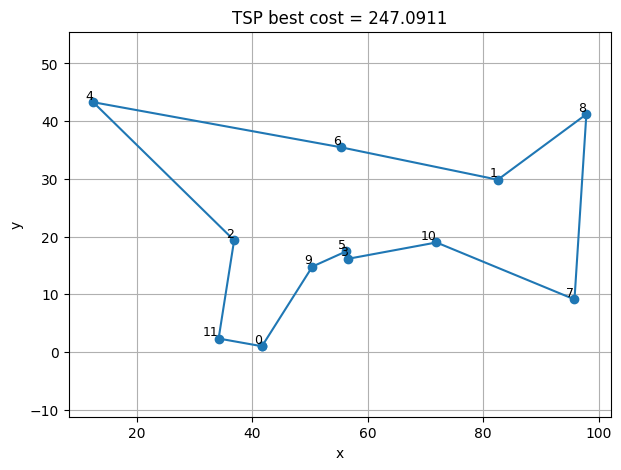

In [30]:
# -------------------------
# Ejemplo: crear problema TSP con coordenadas de ejemplo
# -------------------------
# Ejemplo reproducible (12 ciudades aleatorias)
rng = Random(12345)
n_cities = 12
coords_example = [(rng.random() * 100, rng.random() * 100) for _ in range(n_cities)]

# Crear el problema
tsp = TSPProblem(coords=coords_example)

# -------------------------
# Configurar y ejecutar la colonia ACO
# -------------------------
# Usa las clases del framework: Colony, TwoOptLocalSearch, GreedyWithProbabilisticExploration, MaxMinPheromoneUpdate
# Ajusta parámetros según necesidades (n > 50 puede ser costoso para 3-opt; aquí usamos 2-opt).
colony = Colony(
    problem=tsp,
    num_ants=30,
    generations=200,
    alpha=1.0,
    beta=5.0,  # heurística fuerte para TSP suele ayudar
    pheromone_update=MaxMinPheromoneUpdate(rho=0.02, Q=1.0, min_tau=0.01, max_tau=10.0),
    transition_rule=GreedyWithProbabilisticExploration(q0=0.9),
    local_search=TwoOptLocalSearch(
        max_iterations=100, improvement="first", verbose=False
    ),
    rng_seed=42,
    verbose=True,
)

# Ejecutar (esto puede tardar algunos segundos)
colony.run()

# Mostrar resultado
best = colony.get_best()
if best:
    solution, cost = best
    print("Mejor costo encontrado:", cost)
    print("Mejor tour (lista de índices):", solution)
    # Graficar
    plot_tour(coords_example, solution, title=f"TSP best cost = {cost:.4f}")
else:
    print("No se encontró solución válida.")


In [31]:
# -------------------------
# Ejemplo: crear problema TSP con coordenadas de ejemplo
# -------------------------
# Ejemplo reproducible (500 ciudades aleatorias)
rng = Random(12345)
n_cities = 500
coords_example = [(rng.random() * 100, rng.random() * 100) for _ in range(n_cities)]

# Crear el problema
tsp = TSPProblem(coords=coords_example)

# -------------------------
# Configurar y ejecutar la colonia ACO
# -------------------------
# Usa las clases del framework: Colony, TwoOptLocalSearch, GreedyWithProbabilisticExploration, MaxMinPheromoneUpdate
# Ajusta parámetros según necesidades (n > 50 puede ser costoso para 3-opt; aquí usamos 2-opt).
colony = Colony(
    problem=tsp,
    num_ants=30,
    generations=200,
    alpha=1.0,
    beta=5.0,  # heurística fuerte para TSP suele ayudar
    pheromone_update=MaxMinPheromoneUpdate(rho=0.02, Q=1.0, min_tau=0.01, max_tau=10.0),
    transition_rule=GreedyWithProbabilisticExploration(q0=0.9),
    local_search=TwoOptLocalSearch(
        max_iterations=100, improvement="first", verbose=False
    ),
    rng_seed=42,
    verbose=True,
)

# Ejecutar (esto puede tardar algunos segundos)
colony.run()

# Mostrar resultado
best = colony.get_best()
if best:
    solution, cost = best
    print("Mejor costo encontrado:", cost)
    print("Mejor tour (lista de índices):", solution)
    # Graficar
    plot_tour(coords_example, solution, title=f"TSP best cost = {cost:.4f}")
else:
    print("No se encontró solución válida.")


KeyboardInterrupt: 

In [33]:
# -------------------------
# Ejemplo: crear problema TSP con coordenadas de ejemplo
# -------------------------
# Ejemplo reproducible (500 ciudades aleatorias)
rng = Random(12345)
n_cities = 500
coords_example = [(rng.random() * 1000, rng.random() * 1000) for _ in range(n_cities)]  # escala mayor para mejor separación

# Crear el problema
tsp = TSPProblem(coords=coords_example)

# -------------------------
# Configurar y ejecutar la colonia ACO
# -------------------------
# Usa las clases del framework: Colony, ThreeOptLocalSearch, GreedyWithProbabilisticExploration, BestWorstPheromoneUpdate
# Ajusta parámetros según necesidades (n > 50 puede ser costoso para 3-opt).
colony = Colony(
    problem=tsp,
    num_ants=100,
    generations=200,
    alpha=1.0,
    beta=5.0,  # heurística fuerte para TSP suele ayudar
    pheromone_update=BestWorstPheromoneUpdate(rho=0.02, Q=1.0, worst_penalty=0.5),
    transition_rule=GreedyWithProbabilisticExploration(q0=0.95),
    local_search=ThreeOptLocalSearch(
        max_iterations=6,  # pocas pasadas internas para mantener tiempo razonable
        improvement="first",  # primera mejora encontrada (más rápido)
    ),
    rng_seed=42,
    verbose=True,
)

# Ejecutar (esto puede tardar algunos segundos)
start = time()
colony.run()
elapsed = time() - start
print(f"Tiempo de ejecución: {elapsed:.1f} s")

# Mostrar resultado
best = colony.get_best()
if best:
    solution, cost = best
    print("Mejor costo encontrado:", cost)
    print("Mejor tour (lista de índices):", solution)
    # Graficar
    plot_tour(coords_example, solution, title=f"TSP best cost = {cost:.4f}")
else:
    print("No se encontró solución válida.")


KeyboardInterrupt: 

[Gen 20/200] best_cost = 480.5890408033923
[Gen 40/200] best_cost = 475.17680731782923
[Gen 60/200] best_cost = 475.17680731782923
[Gen 80/200] best_cost = 475.17680731782923
[Gen 100/200] best_cost = 475.17680731782923
[Gen 120/200] best_cost = 475.17680731782923
[Gen 140/200] best_cost = 475.17680731782923
[Gen 160/200] best_cost = 475.17680731782923
[Gen 180/200] best_cost = 475.17680731782923
[Gen 200/200] best_cost = 475.17680731782923
Tiempo de ejecución: 2881.4 s
Mejor costo encontrado: 475.17680731782923
Mejor tour (lista de índices): [0, 11, 16, 26, 28, 4, 19, 24, 14, 12, 17, 25, 18, 20, 15, 27, 13, 23, 8, 7, 22, 1, 21, 10, 6, 5, 3, 29, 9, 2]


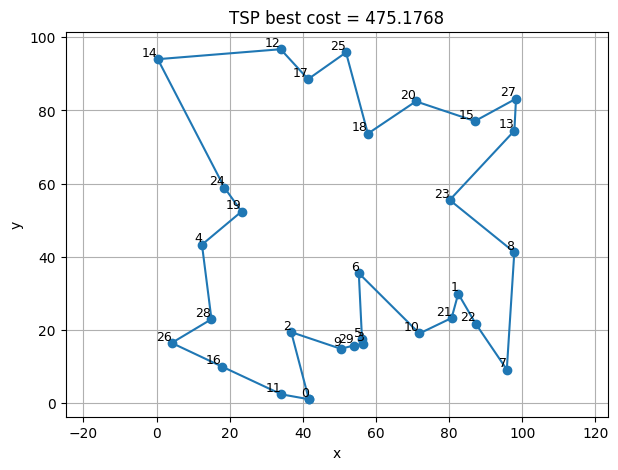

In [34]:
# -------------------------
# Ejemplo: crear problema TSP con coordenadas de ejemplo
# -------------------------
# Ejemplo reproducible (30 ciudades aleatorias)
rng = Random(12345)
n_cities = 30
coords_example = [
    (rng.random() * 100, rng.random() * 100) for _ in range(n_cities)
]  # escala mayor para mejor separación

# Crear el problema
tsp = TSPProblem(coords=coords_example)

# -------------------------
# Configurar y ejecutar la colonia ACO
# -------------------------
# Usa las clases del framework: Colony, ThreeOptLocalSearch, GreedyWithProbabilisticExploration, BestWorstPheromoneUpdate
# Ajusta parámetros según necesidades (n > 50 puede ser costoso para 3-opt).
colony = Colony(
    problem=tsp,
    num_ants=60,
    generations=200,
    alpha=1.0,
    beta=5.0,  # heurística fuerte para TSP suele ayudar
    pheromone_update=BestWorstPheromoneUpdate(rho=0.02, Q=1.0, worst_penalty=0.5),
    transition_rule=GreedyWithProbabilisticExploration(q0=0.95),
    local_search=ThreeOptLocalSearch(
        max_iterations=6,  # pocas pasadas internas para mantener tiempo razonable
        improvement="first",  # primera mejora encontrada (más rápido)
    ),
    rng_seed=42,
    verbose=True,
)

# Ejecutar (esto puede tardar algunos segundos)
start = time()
colony.run()
elapsed = time() - start
print(f"Tiempo de ejecución: {elapsed:.1f} s")

# Mostrar resultado
best = colony.get_best()
if best:
    solution, cost = best
    print("Mejor costo encontrado:", cost)
    print("Mejor tour (lista de índices):", solution)
    # Graficar
    plot_tour(coords_example, solution, title=f"TSP best cost = {cost:.4f}")
else:
    print("No se encontró solución válida.")
